In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
plt.style.use('seaborn')
import datetime as dt
from dateutil.relativedelta import relativedelta


# tcode　preprocess
def tcode_preprocess(df: pd.DataFrame, tcode: int) -> tuple[np.ndarray, pd.Index]:
    date = df.index
    data = np.array(df)
    if tcode == 1:
        return data, date
    elif tcode == 2:
        results = np.diff(data, axis=0)
        return results, date[1:]
    elif tcode == 3:
        results = np.diff(np.diff(np.log(data), axis=0), axis=0)
        return results, date[2:]
    elif tcode == 4:
        results = np.log(data)
        return results, date
    elif tcode == 5:
        results = np.diff(np.log(data), axis=0)
        return results, date[1:]
    elif tcode == 6:
        results = np.diff(np.diff(np.log(data), axis=0), axis=0)
        return results, date[2:]
    elif tcode == 7:
        results = np.diff((data[1:]/data[0:-1])-1, axis=0)
        return results, date[2:]
    else:
        raise ValueError('tcodeは1から7の自然数です')


class VARmodel(object):
    def __init__(self,
                 data: np.ndarray
                 ) -> None:
        self.data = data
        self.data_nrow = data.shape[0]
        self.data_ncol = data.shape[1]

    def IC_order(self, maxLag: int, h: int = 0) -> dict[str, pd.DataFrame | int | int]:
        # k variables VAR(p)
        # y_{t+h}=y_{t-1}+...+y_{t-p}
        # maxLag>=1
        # T >= k*k*p + k
        T = self.data_nrow - maxLag
        ic_results = pd.DataFrame(np.zeros([maxLag, 2]), columns=['AIC', 'BIC'], index=range(1, maxLag+1))
        y_mat = self.data[maxLag+h:]
        y_vec = y_mat.reshape(y_mat.shape[0]*y_mat.shape[1], 1, order='F')
        for p in range(1, maxLag+1):
            x = np.c_[np.ones(self.data_nrow-h-maxLag), self.data[maxLag-1:self.data_nrow-1-h]]
            if maxLag > 1:
                for lag in range(2, p+1):
                    x = np.c_[x, self.data[maxLag-lag:self.data_nrow-lag-h]]
            eye_ncol = np.eye(self.data_ncol)
            xx = np.kron(eye_ncol, x)
            phi_vec = np.linalg.inv(xx.T @ xx) @ xx.T @ y_vec
            # c1, y1t-1, y2t-1, y3t-1, y1t-2, y2t-2, y3t-2
            # c2, y1t-1, y2t-1, y3t-1, y1t-2, y2t-2, y3t-2
            # c3, y1t-1, y2t-1, y3t-1, y1t-2, y2t-2, y3t-2
            residuals = (y_vec - xx @ phi_vec).reshape(self.data_ncol-maxLag-h, self.data_ncol, order='F')
            Sigma_hat = residuals.T @ residuals/T
            aic = np.log(np.linalg.det(Sigma_hat)) + 2*(self.data_ncol*self.data_ncol*p + self.data_ncol) / T
            bic = np.log(np.linalg.det(Sigma_hat)) + (self.data_ncol*self.data_ncol*p + self.data_ncol) * (np.log(T)/T)
            ic_results.loc[p, 'AIC'] = aic
            ic_results.loc[p, 'BIC'] = bic
        lag_aic = int(ic_results['AIC'].idxmin())
        lag_bic = int(ic_results['BIC'].idxmin())
        ic_results.loc[lag_aic, 'AIC'] = str(ic_results.loc[lag_aic, 'AIC']) + '*'
        ic_results.loc[lag_bic, 'BIC'] = str(ic_results.loc[lag_bic, 'BIC']) + '*'
        return {'ic_results': ic_results, 'aic': lag_aic, 'bic': lag_aic}

    def fit(self,
            p: int,
            h: int,
            ic: str = 'aic'
            ) -> pd.DataFrame:
        y_mat = self.data[p+h:]
        y_vec = y_mat.reshape(y_mat.shape[0]*y_mat.shape[1], 1, order='F')
        x = np.c_[np.ones(self.data_nrow-p-h), self.data[p-1:self.data_nrow-1-h]]
        if p > 1:
            for lag in range(2, p+1):
                x = np.c_[x, self.data[p-lag:self.data_nrow-lag-h]]
        eye_ncol = np.eye(self.data_ncol)
        xx = np.kron(eye_ncol, x)
        phi_vec = np.linalg.inv(xx.T @ xx) @ xx.T @ y_vec
        # c1, y1t-1, y2t-1, y3t-1, y1t-2, y2t-2, y3t-2
        # c2, y1t-1, y2t-1, y3t-1, y1t-2, y2t-2, y3t-2
        # c3, y1t-1, y2t-1, y3t-1, y1t-2, y2t-2, y3t-2
        phi_mat = phi_vec.reshape(self.data_ncol, 1+(self.data_ncol*p))
        phi_mat_df = pd.DataFrame(phi_mat)
        col = ['b'+str(i) for i in phi_mat_df.columns]
        index = ['y'+str(i+1) for i in phi_mat_df.index]
        phi_mat_df.columns = col
        phi_mat_df.index = index
        return phi_mat_df

    def forecast(self, p: int, h: int, forecast_length: int) -> np.ndarray:
        y = np.r_[self.data[-p-h:], np.zeros([forecast_length, self.data_ncol])]
        phi = np.array(self.fit(p, h))
        for t in range(forecast_length):
            x = np.flipud(y[t:t+p]).reshape([self.data_ncol*p, 1])
            c = phi[:, 0].reshape([self.data_ncol, 1])
            y[t+p+h] = (c + phi[:, 1:] @ x).T
        forecasts = y[p+h:]
        return forecasts


In [2]:
# read data and Preprocessing
fredmd_all = pd.read_csv('../data/current.csv')
fredmd_Transform = fredmd_all.loc[[0], :].copy()
fredmd_Transform = fredmd_Transform.set_index('sasdate')
fredmd = fredmd_all.loc[1:].copy()
fredmd['sasdate'] = pd.to_datetime(fredmd['sasdate'])
fredmd = fredmd.set_index('sasdate')
fredmd = fredmd.iloc[:-1]  # 最後の行が空行なので削除
datanames = ['RPI', 'DPCERA3M086SBEA', 'IPDCONGD']
data, date = tcode_preprocess(fredmd[datanames], 5)
df3 = pd.DataFrame(data, index=date, columns = datanames)

<AxesSubplot:xlabel='sasdate'>

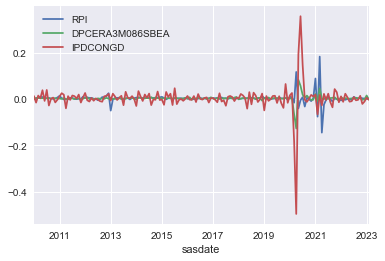

In [3]:
df3.iloc[611:].plot()

In [4]:
fredmd[datanames]

,RPI,DPCERA3M086SBEA,IPDCONGD
sasdate,,,
1959-01-01,2442.158,17.272,19.0149
1959-02-01,2451.778,17.452,19.1147
1959-03-01,2467.594,17.617,19.4890
1959-04-01,2483.671,17.553,19.6138
1959-05-01,2498.026,17.765,20.0130
...,...,...,...
2022-10-01,17872.733,129.111,108.0885
2022-11-01,17916.642,128.577,105.7414
2022-12-01,17936.624,128.328,104.5272


In [5]:
data[611:]

array([[ 5.02783214e-03, -1.83133943e-03,  1.18563454e-02],
       [ 4.21263959e-04,  3.73238140e-03, -1.61902789e-02],
       [ 3.78773504e-03,  4.76801136e-03,  1.42063050e-02],
       [ 8.13111549e-03,  2.04389781e-03,  2.74879905e-03],
       [ 7.82436329e-03,  2.48439617e-03,  3.73178736e-02],
       [ 1.22591382e-03,  2.42667185e-03, -8.81284879e-03],
       [ 2.64363418e-03,  2.73969952e-03,  3.84859037e-02],
       [ 3.98982872e-03,  2.41418217e-03, -2.87056189e-02],
       [ 7.13606550e-04,  9.43541427e-04,  3.44854085e-04],
       [ 6.59640518e-04,  2.53903387e-03,  5.51117804e-03],
       [ 1.16125923e-03,  2.54280264e-03, -1.52624189e-02],
       [ 5.97538531e-03,  1.32500300e-03, -3.63002571e-03],
       [ 1.28084285e-02,  1.10961251e-03,  1.05717842e-02],
       [ 2.78285237e-03, -2.74743447e-04,  2.44517171e-02],
       [-2.42465771e-03,  3.45423487e-03,  1.80865143e-02],
       [-1.71923448e-03, -1.17716317e-03, -4.08351232e-02],
       [-1.26498666e-03, -1.15821891e-03

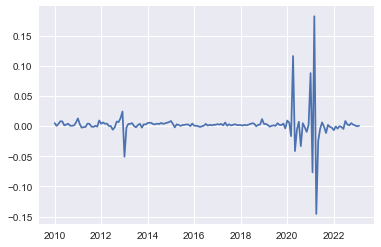

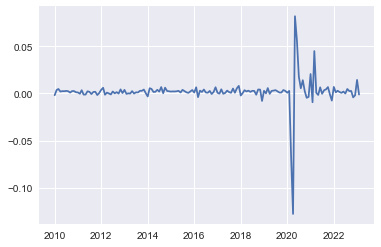

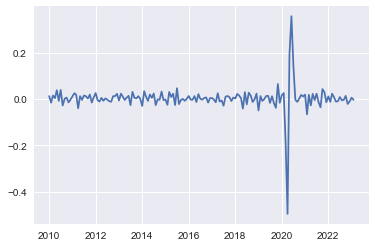

In [6]:
st = 611
plt.plot(date[st:], data[st:, 0])
plt.show()
plt.plot(date[st:], data[st:, 1])
plt.show()
plt.plot(date[st:], data[st:, 2])
plt.show()

In [43]:
np.sum((forecast - data[-forecast.shape[0]:])**2, axis=0)

array([0.00031582, 0.0002599 , 0.00222286])

                   AIC                  BIC
1           -23.441918  -23.18858226154635*
2           -23.526679           -23.083341
3  -23.77723530686957*           -23.143896
4            -23.74853           -22.925188
5           -23.744411           -22.731067


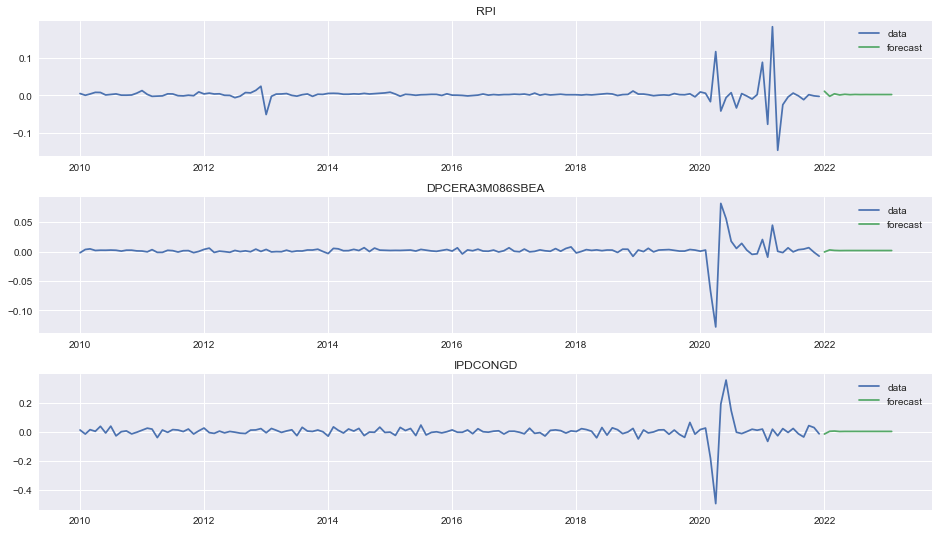

In [51]:

# parameters
maxLag = 5  # max lag of VAR(p)
h = 0  # forecast lag
start = 611
end = 755
learning_data = data[start:end]
forecast_date = date[end:]
forecast_length = len(forecast_date)

model = VARmodel(learning_data)
print(model.IC_order(maxLag, h)['ic_results'])
forecast = model.forecast(p=1, h=h, forecast_length=forecast_length)
forecast_date = date[end:]
a = np.r_[learning_data, forecast]
fig, ax = plt.subplots(len(datanames), 1, figsize=(16,9))
i = 0
fig.subplots_adjust(wspace=1, hspace=0.3)
for i in range(len(datanames)):
    ax[i].plot(date[start:end], learning_data[:,i], label='data')
    ax[i].plot(forecast_date, forecast[:,i], label='forecast')
    ax[i].set_title(datanames[i])
    ax[i].legend()
plt.show()

MSFE0 = np.sum((forecast - data[-forecast.shape[0]:])**2, axis=0)

                    AIC                  BIC
1             -22.81226  -22.55892445508939*
2  -22.955519770744694*           -22.512182
3             -22.89269            -22.25935
4            -22.860054           -22.036713
5            -22.832578           -21.819234


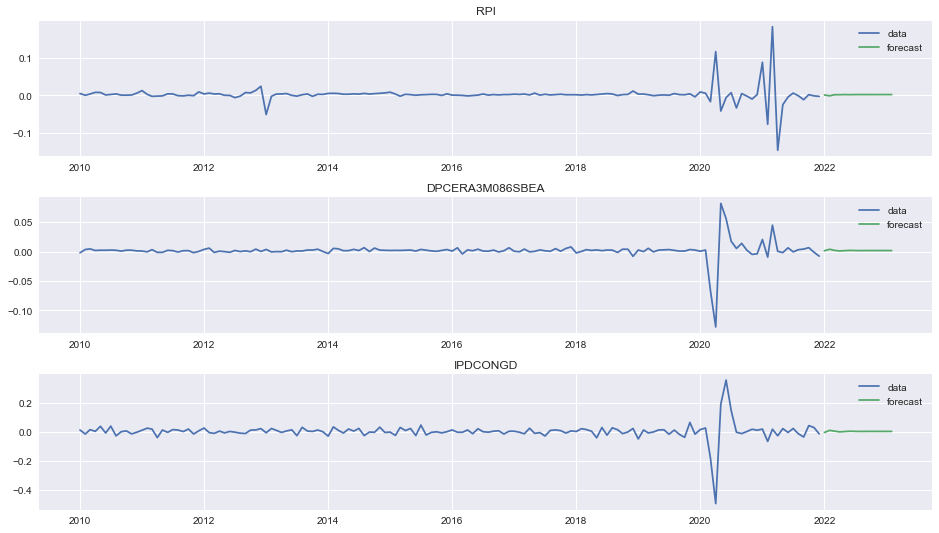

In [52]:

# parameters
maxLag = 5  # max lag of VAR(p)
h = 1  # forecast lag
start = 611
end = 755
learning_data = data[start:end]
forecast_date = date[end:]
forecast_length = len(forecast_date)

model = VARmodel(learning_data)
print(model.IC_order(maxLag, h)['ic_results'])
forecast = model.forecast(p=1, h=h, forecast_length=forecast_length)
forecast_date = date[end:]
a = np.r_[learning_data, forecast]
fig, ax = plt.subplots(len(datanames), 1, figsize=(16,9))
i = 0
fig.subplots_adjust(wspace=1, hspace=0.3)
for i in range(len(datanames)):
    ax[i].plot(date[start:end], learning_data[:,i], label='data')
    # ax[i].plot(forecast_date, data[end:end+forecast_length, i], label='unknown data')
    ax[i].plot(forecast_date, forecast[:,i], label='forecast')
    ax[i].set_title(datanames[i])
    ax[i].legend()
plt.show()
MSFE1 = np.sum((forecast - data[-forecast.shape[0]:])**2, axis=0)

                    AIC                   BIC
1  -22.898359351280334*  -22.645023472161135*
2            -22.802423            -22.359085
3            -22.733259            -22.099919
4            -22.696435            -21.873094
5            -22.646142            -21.632798


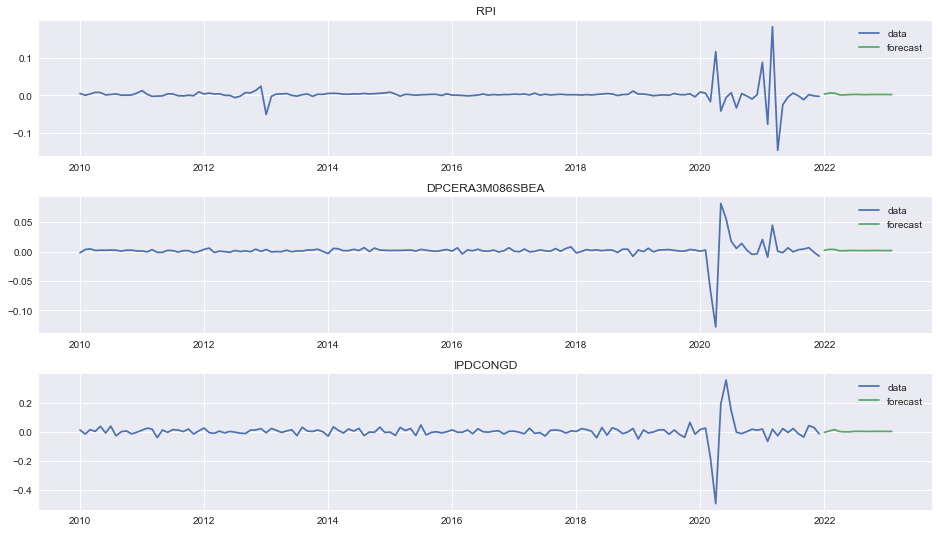

In [59]:

# parameters
maxLag = 5  # max lag of VAR(p)
h = 2  # forecast lag

start = 611
end = 755
learning_data = data[start:end]
forecast_date = date[end:]
forecast_length = len(forecast_date)

model = VARmodel(learning_data)
print(model.IC_order(maxLag, h)['ic_results'])
forecast = model.forecast(p=1, h=h, forecast_length=forecast_length)
forecast_date = date[end:]
a = np.r_[learning_data, forecast]
fig, ax = plt.subplots(len(datanames), 1, figsize=(16,9))
i = 0
fig.subplots_adjust(wspace=1, hspace=0.3)
for i in range(len(datanames)):
    ax[i].plot(date[start:end], learning_data[:,i], label='data')
    # ax[i].plot(forecast_date, data[end:end+forecast_length, i], label='unknown data')
    ax[i].plot(forecast_date, forecast[:,i], label='forecast')
    ax[i].set_title(datanames[i])
    ax[i].legend()
plt.show()
forecast2 = forecast.copy()
MSFE2 = np.sum((forecast - data[-forecast.shape[0]:])**2, axis=0)

                    AIC                   BIC
1  -22.572303806081642*  -22.318967926962443*
2             -22.51567            -22.072332
3            -22.434216            -21.800876
4            -22.350715            -21.527373
5            -22.255758            -21.242415


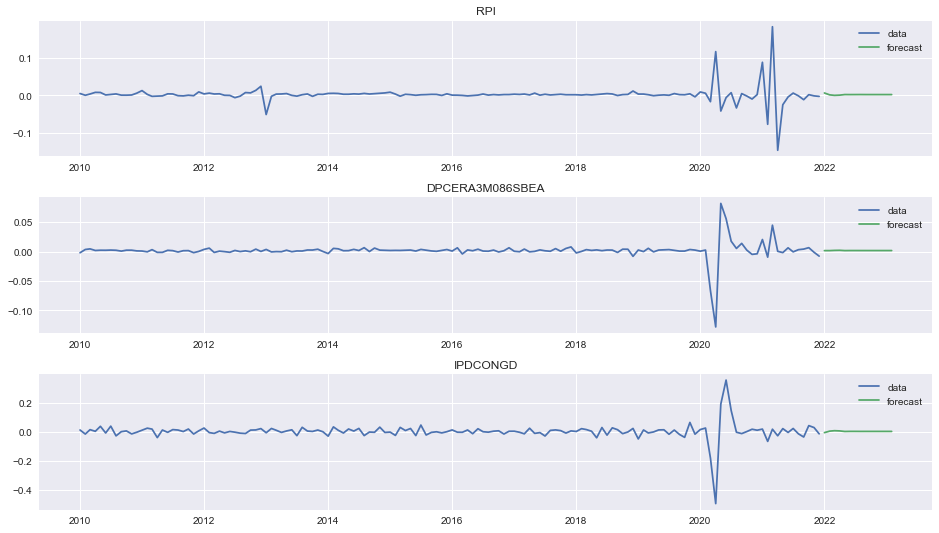

In [60]:

# parameters
maxLag = 5  # max lag of VAR(p)
h = 3  # forecast lag
start = 611
end = 755
learning_data = data[start:end]
forecast_date = date[end:]
forecast_length = len(forecast_date)

model = VARmodel(learning_data)
print(model.IC_order(maxLag, h)['ic_results'])
forecast = model.forecast(p=1, h=h, forecast_length=forecast_length)
forecast_date = date[end:]
a = np.r_[learning_data, forecast]
fig, ax = plt.subplots(len(datanames), 1, figsize=(16,9))
i = 0
fig.subplots_adjust(wspace=1, hspace=0.3)
for i in range(len(datanames)):
    ax[i].plot(date[start:end], learning_data[:,i], label='data')
    # ax[i].plot(forecast_date, data[end:end+forecast_length, i], label='unknown data')
    ax[i].plot(forecast_date, forecast[:,i], label='forecast')
    ax[i].set_title(datanames[i])
    ax[i].legend()
plt.show()
forecast3 = forecast.copy()
MSFE3 = np.sum((forecast - data[-forecast.shape[0]:])**2, axis=0)

In [61]:
print(forecast2)
print(forecast3)

[[ 0.0034871   0.00243444 -0.00438641]
 [ 0.00647361  0.00399964  0.00594643]
 [ 0.00597973  0.00376852  0.01467891]
 [ 0.00140398  0.00149098  0.00144747]
 [ 0.00128991  0.00161304 -0.00085822]
 [ 0.00222478  0.00209419 -0.00059751]
 [ 0.00257112  0.00199862  0.00276085]
 [ 0.00231487  0.00184729  0.00263377]
 [ 0.00201872  0.00174298  0.00194751]
 [ 0.00233564  0.00194393  0.00201411]
 [ 0.00242153  0.00197552  0.00222735]
 [ 0.00243766  0.00196498  0.00238862]
 [ 0.00231651  0.00191744  0.00210814]
 [ 0.00231243  0.0019208   0.00205955]]
[[ 0.00648467  0.00179823 -0.00636082]
 [ 0.00148801  0.00181621  0.0039689 ]
 [ 0.00016358  0.00217487  0.00693922]
 [ 0.00076226  0.00234397  0.00547982]
 [ 0.00229713  0.00183262  0.00165196]
 [ 0.00218378  0.00192324  0.00228086]
 [ 0.00224851  0.00193139  0.00224567]
 [ 0.00232696  0.00191166  0.00202982]
 [ 0.00224467  0.00190537  0.00208386]
 [ 0.00224719  0.00190457  0.00208961]
 [ 0.0022456   0.00190335  0.00208861]
 [ 0.0022445   0.0019026

In [63]:
print(MSFE0)
print(MSFE1)
print(MSFE2)
print(MSFE3)

[0.00050974 0.00029119 0.00272121]
[0.00021561 0.00027043 0.00256052]
[0.00036618 0.00026235 0.00197421]
[0.00031582 0.0002599  0.00222286]


In [12]:
fredmd_transformed = fredmd.copy()
for i in tqdm(fredmd.columns):
    ft, _ = tcode_preprocess(fredmd[i], int(fredmd_Transform[i].values[0]))
    fredmd_transformed[i][-len(ft):] = ft
    fredmd_transformed[i][:-len(ft)] = None

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 1834.78it/s]


<AxesSubplot:xlabel='sasdate'>

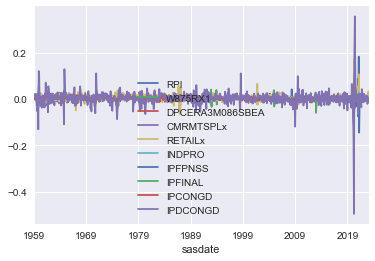

In [13]:
fredmd_transformed.iloc[:, :10].plot()

In [162]:
N =10
C = 3
a = np.zeros([N, C]).astype(str)
for n in range(N):
    for c in range(C):
        a[n,c] = f'y_{n}_{c}'
a

array([['y_0_0', 'y_0_1', 'y_0_2'],
       ['y_1_0', 'y_1_1', 'y_1_2'],
       ['y_2_0', 'y_2_1', 'y_2_2'],
       ['y_3_0', 'y_3_1', 'y_3_2'],
       ['y_4_0', 'y_4_1', 'y_4_2'],
       ['y_5_0', 'y_5_1', 'y_5_2'],
       ['y_6_0', 'y_6_1', 'y_6_2'],
       ['y_7_0', 'y_7_1', 'y_7_2'],
       ['y_8_0', 'y_8_1', 'y_8_2'],
       ['y_9_0', 'y_9_1', 'y_9_2']], dtype='<U32')

In [163]:
model = VARmodel(a)
maxL = 2
h = 0
print(model.IC_order(maxL, h)['ic_results'])
forecast_length

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('float64'), dtype('<U32')) -> None